# GANs


## Libaries

As always, we load lots of libraries.

In [1]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Data

We will be using the FashionMNIST data set.

In [2]:
# A transform to convert the images to tensor and normalize their RGB values
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])]
)

data = datasets.FashionMNIST(root='../data/', train=True, transform=transform, download=True)

batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12676414.29it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202995.34it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3778573.90it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7392083.87it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



## Helper Functions

We'll need several helper functions for training the conditional GAN. The first converts labels to one hot encoded vectors, we will use it to pass the desired label to the generator. The second will plot a grid of 10x10 images from the generator.

In [3]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [4]:
to_onehot(3)

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

For GAN without conditioning

In [5]:
def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([280, 280])

    for j in range(10):
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j * 28:(j + 1) * 28] = np.concatenate([x for x in result], axis=-1)

    return img

## Architecture

GAN without conditioning

In [6]:
class Generator(nn.Module):
    def __init__(self, input_size=100, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        return y_


## Set up and Training

Now, we're ready to instantiate our models, hyperparameters, and optimizers. Since the task is so easy for MNIST, we will train for only 10 epochs. We will update the generator and discriminator in every step but often one can be trained more frequently than the other.

In [7]:
MODEL_NAME = 'GAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator().to(DEVICE) # randomly intialized
G = Generator().to(DEVICE) # randomly initialized

max_epoch = 10
step = 0
n_noise = 100 # size of noise vector

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
all_ones = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
all_zeros = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [8]:
images, class_labels = next(iter(data_loader))
print(images.shape, class_labels.shape)
class_labels_encoded = class_labels.view(batch_size, 1)
class_labels_encoded = to_onehot(class_labels_encoded).to(DEVICE)
print(class_labels[:10])
print(class_labels_encoded[:10])

torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor([0, 4, 1, 5, 4, 8, 3, 2, 1, 0])
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


GAN Without Conditioning

In [9]:
# A directory to save the generated images
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images, class_labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)  # No class labels
        D_x_loss = criterion(x_outputs, all_ones)  # Discriminator loss for real images

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))  # No class labels
        D_z_loss = criterion(z_outputs, all_zeros)  # Discriminator loss for fake images
        D_loss = D_x_loss + D_z_loss  # Total Discriminator loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        G_loss = -1 * criterion(z_outputs, all_zeros)  # Generator loss is negative discriminator loss

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1


Epoch: 0/10, Step: 0, D Loss: 1.4550912380218506, G Loss: -0.6846458911895752
Epoch: 0/10, Step: 500, D Loss: 1.2414472103118896, G Loss: -0.6015386581420898
Epoch: 1/10, Step: 1000, D Loss: 1.1197433471679688, G Loss: -0.45712167024612427
Epoch: 1/10, Step: 1500, D Loss: 1.3019194602966309, G Loss: -0.5231057405471802
Epoch: 2/10, Step: 2000, D Loss: 1.2857389450073242, G Loss: -0.5418015122413635
Epoch: 2/10, Step: 2500, D Loss: 1.2765604257583618, G Loss: -0.5797858834266663
Epoch: 3/10, Step: 3000, D Loss: 1.371246337890625, G Loss: -0.6444132328033447
Epoch: 3/10, Step: 3500, D Loss: 1.3316274881362915, G Loss: -0.5640603303909302
Epoch: 4/10, Step: 4000, D Loss: 1.2915987968444824, G Loss: -0.5313429832458496
Epoch: 4/10, Step: 4500, D Loss: 1.2221126556396484, G Loss: -0.41334447264671326
Epoch: 5/10, Step: 5000, D Loss: 1.3421097993850708, G Loss: -0.6447148323059082
Epoch: 5/10, Step: 5500, D Loss: 1.35707688331604, G Loss: -0.5243163108825684
Epoch: 6/10, Step: 6000, D Loss: 

Now let's plot these images. At first, the generator just produces noise (as we expect). but as the training steps increases, GAN generates better images. We can recognize the items (e.g., shoe, shirt, pants) it produces.

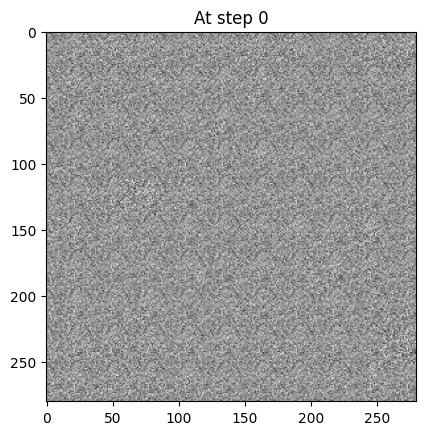

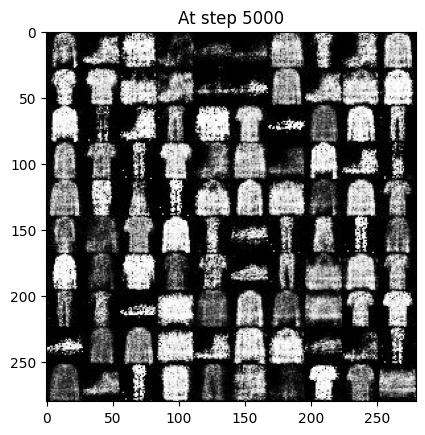

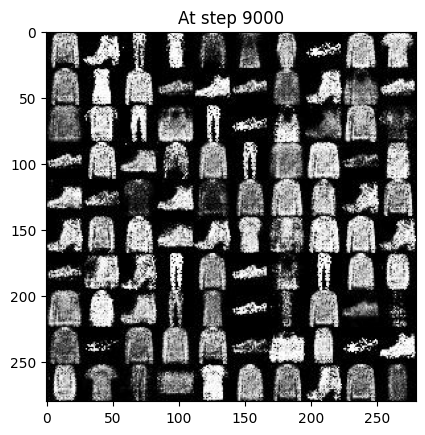

In [11]:
img = mpimg.imread('samples/GAN_step000.jpg')
imgplot = plt.imshow(img)
plt.title('At step 0')
plt.show()

img = mpimg.imread('samples/GAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.title('At step 5000')
plt.show()

img = mpimg.imread('samples/GAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.title('At step 9000')
plt.show()

Now, I will generate some sample images and calculate evaluation metrics.

In [22]:
from torchvision.utils import save_image
def generate_samples(num_samples):
    z = torch.randn(num_samples, n_noise).to(DEVICE)
    samples = G(z)
    return samples

# Generate samples
generated_images = generate_samples(10000)
# Save samples
if not os.path.exists('generated_image'):
    os.makedirs('generated_image')
for i,image in enumerate(generated_images):
  save_image(image,'generated_image/{}.jpg'.format(str(i)))

In [24]:
#!pip install torch_fidelity
from torch.utils.data import Dataset
import torch_fidelity

class DatasetWithoutLabel(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        image,_= self.dataset[index]
        return image
    def __len__(self):
        return len(self.dataset)

transform = transforms.Compose([
   transforms.Grayscale(num_output_channels=3),
   transforms.ToTensor(),
   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
   transforms.Lambda(lambda x:x.mul(255).byte()) ,
])

data = datasets.FashionMNIST(root='../data/', train=True, transform=transform, download=True)

data_without_label = DatasetWithoutLabel(data)

# Calculate metrics
metrics_dict = torch_fidelity.calculate_metrics(
    input1='generated_image',
    input2=data_without_label,
    cuda=True,
    isc=True,
    fid=True,
    kid=True,
)

print(metrics_dict)

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "generated_image" with extensions png,jpg,jpeg
Found 10000 samples, some are lossy-compressed - this may affect metrics
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Processing samples
Extracting features from input2
Processing samples
Inception Score: 2.455889091085612 ± 0.02974694085603538
Frechet Inception Distance: 168.15779876490234
Kernel Inception Distance: 0.1522729755255255 ± 0.003708164575583822

{'inception_score_mean': 2.455889091085612, 'inception_score_std': 0.02974694085603538, 'frechet_inception_distance': 168.15779876490234, 'kernel_inception_distance_mean': 0.1522729755255255, 'kernel_inception_distance_std': 0.0037081645755838223}


I have used Inception score (IS), FID, and KID for measuring GAN performance. They provide insight on the generated image quality and diversity. A higher IS is better representing that the genrerated images have better quality and contains all classes of images. In the above GAN model, we got an IS around 2.455, which is expected, as the model is trained only for 10 epochs and the generated image quality is not good. However, IS has limitations as it does not consider real images for comparison. On the other hand, FID quantifies the similarity between the distribution of real images and generated images in feature space and KID uses kernelized distance metrics for feature space comparison. Lower FID and KID means better quality and diversity. Although we get high value of FID and KID from our GAN model, we can visually recognize the items in FashionMNIST dataset.

<br/>
Finally, by visually inspecting the generated images from GAN and conditional GAN, it is seen that they produce almost similar performance. Although it is expected for conditional GAN to perform slightly better than the GAN, the difference is not signficant in the generated images.